In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import numpy as np

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.func as func
#import mlgrad.regular as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager

import sklearn.linear_model as linear_model

from mlgrad import averager_it, averager_fg, fg, erm_fg, irgd, erm_irgd, erisk, aerisk

In [2]:
def gendataset(N=200, a=3., b=9., q=0.4, dy=2.):
    M = int(q*N)
    X0 = np.linspace(-10., 10., N+1)
    Y0 = 2.+3.*X0
    Y0 += 2*dy*np.random.random(N+1)-dy
    if q > 0:
        X1 = a*np.random.random(M) - a - 10
        Y1 = b*(2*np.random.random(M)-1)
        Y1 += 2.+3.*X1 + 50
        X2 = a*np.random.random(M) - a + 11
        Y2 = b*(2*np.random.random(M)-1)
        Y2 += 2.+3.*X2 - 50
        X = np.hstack((X0, X1, X2))
        Y = np.hstack((Y0, Y1, Y2))
    else:
        X = X0
        Y = Y0
    Xs = X.reshape(-1,1)
    xrange = np.array(np.linspace(-10., 10., 10)).reshape(-1,1)
    return X, Y, Xs, xrange

In [3]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt())
loss_func_logsq = loss.ErrorLoss(func.LogSquare())
# loss_func_abs = loss.ErrorLoss(func.Absolute())
# loss_func_tukey = loss.ErrorLoss(func.Tukey(30.))

In [4]:
q = 0.0
Q = 100 // (1+q)
dy = 3
X0, Y0, X0s, xrange0  = gendataset(q=q, dy=dy)

701


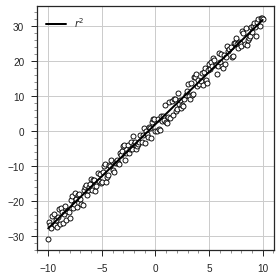

In [5]:
m0 = X0s.shape[1] + 1
param_init0 = np.array(np.random.random(m0))
lm_line0 = model.LinearModel(param_init0)
er0 = erisk(X0s, Y0, lm_line0, loss_func_sq)
alg0 = erm_fg(er0, h=0.01, tol=1.0e-6, n_iter=1000)
print(alg0.K)

plt.figure(figsize=(4., 4.))
plt.scatter(X0, Y0, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange0, alg0.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label=r'$r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
q = 0.49
Q = 100 * 2*q / (1+2*q)
dy = 4
X2, Y2, X2s, xrange2  = gendataset(q=q, dy=dy)

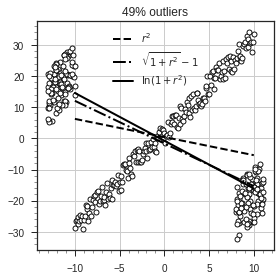

In [7]:
param_init2_sq = np.array([0.,-1.])
param_init2_sqrt = np.array([0.,-1.])
param_init2_logsq = np.array([0.,-1.])
lm_line2_sq = model.LinearModel(param_init2_sq)
lm_line2_sqrt = model.LinearModel(param_init2_sqrt)
# lm_line2_logsq = model.LinearModel(param_init2_logsq)
lm_line2_logsq = model.LinearModel(param_init2_logsq)
er2_sq = erisk(X2s, Y2, lm_line2_sq, loss_func_sq)
er2_sqrt = erisk(X2s, Y2, lm_line2_sqrt, loss_func_sqrt)
er2_logsq = erisk(X2s, Y2, lm_line2_logsq, loss_func_logsq)
alg2_sq = erm_fg(er2_sq, h=0.1, tol=1.0e-6, n_iter=1000)
alg2_sqrt = erm_fg(er2_sqrt, h=0.1, tol=1.0e-6, n_iter=1000)
alg2_logsq = erm_fg(er2_logsq, h=0.1, tol=1.0e-6, n_iter=1000)

plt.figure(figsize=(4., 4.))
plt.title("%.0f%% outliers" % Q)
plt.scatter(X2, Y2, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange2, alg2_sq.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$r^2$', linestyle='--')
plt.plot(xrange2, alg2_sqrt.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$\sqrt{1+r^2}-1$', linestyle='-.')
plt.plot(xrange2, alg2_logsq.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$\ln(1+r^2)$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/linear_regression_1_%.0f.eps" % Q)
plt.show()

In [8]:
# alg_ridge = linear_model.Ridge(alpha=100.)
# alg_ridge.fit(X2s, Y2)
# alg_lasso = linear_model.Lasso(alpha=100.)
# alg_lasso.fit(X2s, Y2)

# plt.figure(figsize=(4.5, 4.5))
# plt.title("Linear regression 80% outliers")
# plt.scatter(X2, Y2, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
# plt.plot(xrange2, alg_lasso.predict(xrange2), color='k', linewidth=2., label=r'LASSO', linestyle='-.')
# plt.plot(xrange2, alg_ridge.predict(xrange2), color='k', linewidth=2., label=r'RIDGE', linestyle='--')
# plt.grid(1)
# plt.minorticks_on()
# plt.legend()
# plt.tight_layout()
# plt.savefig("fig/resistant_linear_lasso_80.png")
# plt.show()

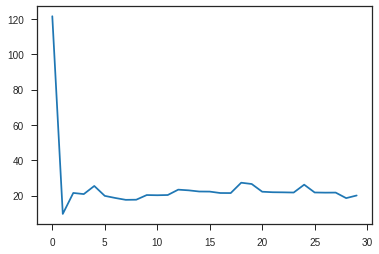

In [9]:
penalty_func_sq2 = func.Sqrt(0.001)

param_init4 = np.array([0.,-1.])
lm_line4 = model.LinearModel(param_init4)

alpha = 0.99 - 2*q/(1+2*q)

irgd2_avrfunc = averager_it(func.QuantileFunc(alpha, penalty_func_sq2), n_iter=5000)
er2 = erisk(X2s, Y2, lm_line4, loss_func_sq)    
irgd2_fg = fg(er2, h=0.001, tol=1.0e-7, n_iter=5000)
irgd2_weights = weights.MWeights(irgd2_avrfunc, er2)
alg_irgd2 = erm_irgd(irgd2_fg, irgd2_weights, n_iter=30)

plt.plot(alg_irgd2.lvals)
plt.show()

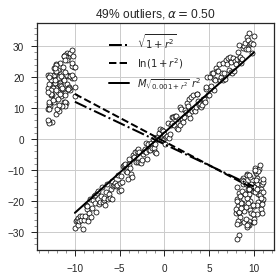

In [10]:
plt.figure(figsize=(4.,4.))
plt.title(r"%.0f%% outliers, $\alpha=$%.2f" % (Q,alpha))
plt.scatter(X2, Y2, s=25, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
# plt.plot(xrange2, alg2_sq.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'LS', linestyle='--')
plt.plot(xrange2, alg2_sqrt.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$\sqrt{1+r^2}$', linestyle='-.')
plt.plot(xrange2, alg2_logsq.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$\ln(1+r^2)$', linestyle='--')
plt.plot(xrange2, alg_irgd2.gd.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label='$M_{\sqrt{0.001+r^2}}\ r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/resistant_linear_2_%.0f.eps" % Q)
plt.show()

In [11]:
penalty_func_sq3 = func.Sqrt(0.001)

param_init5 = np.array([0.,-1.])
lm_line5 = model.LinearModel(param_init5)

alpha = 1.0 - 2*q/(1+2*q)

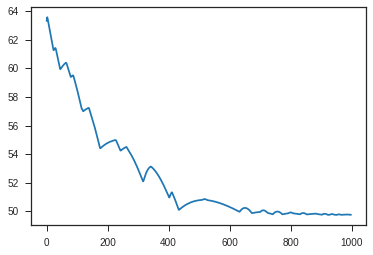

In [12]:
avrfunc3 = averager_it(func.QuantileFunc(alpha, penalty_func_sq3), n_iter=5000)
er3 = aerisk(X2s, Y2, lm_line5, loss_func_sq, avrfunc3)    
fg3 = erm_fg(er3, h=0.001, tol=1.0e-9, n_iter=1000)

plt.plot(fg3.lvals)
plt.show()

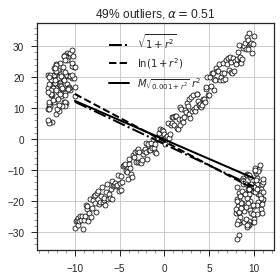

In [13]:
plt.figure(figsize=(4.,4.))
plt.title(r"%.0f%% outliers, $\alpha=$%.2f" % (Q,alpha))
plt.scatter(X2, Y2, s=25, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
# plt.plot(xrange2, alg2_sq.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'LS', linestyle='--')
plt.plot(xrange2, alg2_sqrt.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$\sqrt{1+r^2}$', linestyle='-.')
plt.plot(xrange2, alg2_logsq.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label=r'$\ln(1+r^2)$', linestyle='--')
plt.plot(xrange2, fg3.risk.model.evaluate_all(xrange2), color='k', linewidth=2., label='$M_{\sqrt{0.001+r^2}}\ r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/resistant_linear_3_%.0f.eps" % Q)
plt.show()